## Introduction to the assignment

For this assignment, you will be using data from the [Progresa program](http://en.wikipedia.org/wiki/Oportunidades), a government social assistance program in Mexico. This program, as well as the details of its impact, are described in the paper "[School subsidies for the poor: evaluating the Mexican Progresa poverty program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)", by Paul Shultz (available on Canvas). Please familiarize yourself with the PROGRESA program before beginning this problem set, so you have a rough sense of where the data come from and how they were generated. If you just proceed into the problem set without understanding Progresa or the data, it will be very difficult!

The goal of this problem set is to implement some of the basic econometric techniques that you are learning in class to measure the impact of Progresa on secondary school enrollment rates. The timeline of the program was:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of data collected in 1998
 * "Wave 2 of data" collected in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
When you are ready, download the progresa_sample.csv data from Canvas. The data are actual data collected to evaluate the impact of the Progresa program.  In this file, each row corresponds to an observation taken for a given child for a given year. There are two years of data (1997 and 1998), and just under 40,000 children who are surveyed in each year. For each child-year observation, the following variables are collected:

| Variable name | Description|
|---------|---------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = 'pobre'|
|progresa |treatment = 'basal'|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	  |gender of head of household (male=1)|
|hohage   |age of head of household|
|age      |years old|
|folnum	  |individual id|
|village  |	village id|
|sc97	  |schooling in 1997|

In [26]:
#Packages
import sys; print(sys.version)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
%matplotlib inline

3.6.0 |Anaconda 4.3.1 (64-bit)| (default, Dec 23 2016, 11:57:41) [MSC v.1900 64 bit (AMD64)]


In [27]:
progresa = pd.read_csv('progresa_sample.csv')

In [28]:
#Converting variables poor and progresa into numeric values 0/1
#pobre --> 1
#no pobre --> 0
#basal --> 1
#control --> 0
progresa.loc[progresa.poor == 'pobre','poor'] = 1
progresa.loc[progresa.poor == 'no pobre','poor'] = 0
progresa.loc[progresa.progresa == 'basal','progresa'] = 1
progresa.loc[progresa.progresa == '0','progresa'] = 0

---
##Part 1: Descriptive analysis

### 1.1	Summary Statistics

a) Present number of missing observations for every single variable


In [29]:
progresa.isnull().sum()

year                0
sex                24
indig             300
dist_sec            0
sc               8453
grc              6549
fam_n               0
min_dist            0
dist_cap            0
poor                0
progresa            0
hohedu              0
hohwag              0
welfare_index     210
hohsex             20
hohage             10
age                 0
village             0
folnum              0
grc97               0
sc97             3872
dtype: int64

b) Present summary statistics (mean and standard deviation) for all of the demographic variables in the dataset (i.e., everything except year, folnum, village). Present these in a single table alphabetized by variable name. Do NOT simply expect the grader to scroll through your output!

In [30]:
x = progresa[progresa.columns.difference(['year','folnum','village'])].describe()
progresa_mean_std = x.loc['mean':'std',:]
progresa_mean_std.T

,mean,std
age,11.366460,3.167744
dist_cap,147.674452,76.063134
dist_sec,2.418910,2.234109
fam_n,7.215715,2.352900
grc,3.963537,2.499063
grc97,3.705372,2.572387
hohage,44.436717,11.620372
hohedu,2.768104,2.656106
hohsex,0.925185,0.263095
hohwag,586.985312,788.133664


### 1.2 Differences at baseline?

Are the baseline (1997) demographic characteristics **for the poor**  different in treatment and control villages? Hint: Use a T-Test to determine whether there is a statistically significant difference in the average values of each of the variables in the dataset. Focus only on the data from 1997 for individuals who are poor (i.e., poor=='pobre').

Present your results in a single table with the following columns and 14 (or so) rows:

| Variable name | Average value (Treatment villages) | Average value (Control villages) | Difference (Treat - Control) | p-value |
|------|------|------|------|------|
|Male  |?     |?     |?     |?     |


In [31]:
#Subset data
poor_97 = progresa[(progresa.poor==1)&(progresa.year==97)]

In [32]:
#Create separate treatment and control set
treatment_poor_97 = poor_97.loc[poor_97.progresa==1]
control_poor_97 = poor_97.loc[poor_97.progresa==0]

In [33]:
# Calculating avg value for treatment 
x = treatment_poor_97[treatment_poor_97.columns.difference(['year','folnum','village','sc97','grc97'])].describe()
avg_treatment_poor_97 = x.loc['mean']

In [34]:
#Create the df structure with variable and avg value for treatment
df1 = pd.DataFrame({'Variable name':avg_treatment_poor_97.index, 'Average value (Treatment villages)':avg_treatment_poor_97.values},
                        columns = ['Variable name','Average value (Treatment villages)'])
df1

,Variable name,Average value (Treatment villages)
0,age,10.716991
1,dist_cap,150.829074
2,dist_sec,2.453122
3,fam_n,7.281327
4,grc,3.531599
5,hohage,43.648828
6,hohedu,2.663139
7,hohsex,0.924656
8,hohwag,544.339544
9,indig,0.325986


In [35]:
#Avg value of control
y = control_poor_97[control_poor_97.columns.difference(['year','folnum','village','sc97','grc97'])].describe()
avg_control_poor_97 = y.loc['mean']

In [36]:
#Create Dataframe
df2 = pd.DataFrame({'Variable name':avg_control_poor_97.index,'Average value (Control villages)':avg_control_poor_97.values},
                      columns = ['Variable name','Average value (Control villages)'])

In [37]:
#Merge df1 and df2
result_df=pd.merge(df1,df2, on = 'Variable name')
result_df

,Variable name,Average value (Treatment villages),Average value (Control villages)
0,age,10.716991,10.742023
1,dist_cap,150.829074,153.769730
2,dist_sec,2.453122,2.507662
3,fam_n,7.281327,7.302469
4,grc,3.531599,3.543050
5,hohage,43.648828,44.276918
6,hohedu,2.663139,2.590348
7,hohsex,0.924656,0.922947
8,hohwag,544.339544,573.163558
9,indig,0.325986,0.332207


In [38]:
from scipy.stats import ttest_ind

In [39]:
#Fill NA with 0 
treatment_poor_97 = treatment_poor_97.fillna(0)
control_poor_97 = control_poor_97.fillna(0)

In [40]:
# Calculating p-value for continuous variable

#Saving p-value in a dict
p = {}
t = {}

#Age
p = {'age': ttest_ind(treatment_poor_97.age,control_poor_97.age).pvalue}
t = {'age': ttest_ind(treatment_poor_97.age,control_poor_97.age).statistic}

#dist_cap
p.update({'dist_cap': ttest_ind(treatment_poor_97.dist_cap,control_poor_97.dist_cap).pvalue})
t.update({'dist_cap': ttest_ind(treatment_poor_97.dist_cap,control_poor_97.dist_cap).statistic})

#dist_sec
p.update({'dist_sec': ttest_ind(treatment_poor_97.dist_sec,control_poor_97.dist_sec).pvalue})
t.update({'dist_sec': ttest_ind(treatment_poor_97.dist_sec,control_poor_97.dist_sec).statistic})

#fam_n
p.update({'fam_n': ttest_ind(treatment_poor_97.fam_n,control_poor_97.fam_n).pvalue})
t.update({'fam_n': ttest_ind(treatment_poor_97.fam_n,control_poor_97.fam_n).statistic})

#grc
p.update({'grc': ttest_ind(treatment_poor_97.grc,control_poor_97.grc).pvalue})
t.update({'grc': ttest_ind(treatment_poor_97.grc,control_poor_97.grc).statistic})

#hohage
p.update({'hohage': ttest_ind(treatment_poor_97.hohage,control_poor_97.hohage).pvalue})
t.update({'hohage': ttest_ind(treatment_poor_97.hohage,control_poor_97.hohage).statistic})

#hohedu
p.update({'hohedu': ttest_ind(treatment_poor_97.hohedu,control_poor_97.hohedu).pvalue})
t.update({'hohedu': ttest_ind(treatment_poor_97.hohedu,control_poor_97.hohedu).statistic})

#hohsex
p.update({'hohsex': ttest_ind(treatment_poor_97.hohsex,control_poor_97.hohsex).pvalue})
t.update({'hohsex': ttest_ind(treatment_poor_97.hohsex,control_poor_97.hohsex).statistic})

#hohwag
p.update({'hohwag': ttest_ind(treatment_poor_97.hohwag,control_poor_97.hohwag).pvalue})
t.update({'hohwag': ttest_ind(treatment_poor_97.hohwag,control_poor_97.hohwag).statistic})

#indig
p.update({'indig': ttest_ind(treatment_poor_97.indig,control_poor_97.indig).pvalue})
t.update({'indig': ttest_ind(treatment_poor_97.indig,control_poor_97.indig).statistic})

#min_dist
p.update({'min_dist': ttest_ind(treatment_poor_97.min_dist,control_poor_97.min_dist).pvalue})
t.update({'min_dist': ttest_ind(treatment_poor_97.min_dist,control_poor_97.min_dist).statistic})

#sc
p.update({'sc': ttest_ind(treatment_poor_97.sc,control_poor_97.sc).pvalue})
t.update({'sc': ttest_ind(treatment_poor_97.sc,control_poor_97.sc).statistic})

#sex
p.update({'sex': ttest_ind(treatment_poor_97.sex,control_poor_97.sex).pvalue})
t.update({'sex': ttest_ind(treatment_poor_97.sex,control_poor_97.sex).statistic})

#welfare_index
p.update({'welfare_index': ttest_ind(treatment_poor_97.welfare_index,control_poor_97.welfare_index).pvalue})
t.update({'welfare_index': ttest_ind(treatment_poor_97.welfare_index,control_poor_97.welfare_index).statistic})


In [41]:
df3 = pd.DataFrame(list(t.items()),
                  columns = ['Variable name','Difference(Treat - Control)'])

In [42]:
df4 = pd.DataFrame(list(p.items()),
                  columns = ['Variable name','p-value'])

In [43]:
#Merge result_df and df3
df5=pd.merge(result_df,df3, how='left' ,on = 'Variable name')
df6=pd.merge(df5,df4, how='left' ,on = 'Variable name')
df6

,Variable name,Average value (Treatment villages),Average value (Control villages),Difference(Treat - Control),p-value
0,age,10.716991,10.742023,-0.708630,4.785594e-01
1,dist_cap,150.829074,153.769730,-3.339081,8.415005e-04
2,dist_sec,2.453122,2.507662,-2.100433,3.569843e-02
3,fam_n,7.281327,7.302469,-0.794167,4.271039e-01
4,grc,3.531599,3.543050,-0.400196,6.890151e-01
5,hohage,43.648828,44.276918,-4.810013,1.515918e-06
6,hohedu,2.663139,2.590348,2.541229,1.105093e-02
7,hohsex,0.924656,0.922947,0.493343,6.217737e-01
8,hohwag,544.339544,573.163558,-3.594588,3.253835e-04
9,indig,0.325986,0.332207,-1.211794,2.255999e-01


### 1.3 Interpretation

* A: Are there statistically significant differences between treatment and control villages as baseline? 
* B: Why does it matter if there are differences at baseline?
* C: What does this imply about how to measure the impact of the treatment?

A: Yes, there are statistically significant differences between the treatment and control villages at baseline as the p-value is lower than 0.05 for certain variables.
For example, the following variables have statistically significant differences:
dist_cap, dist_sec, hohage, hohedu, hohwag, min_dist, sc and sex

B: Differences at baseline indicate that the process of randomization that aims to make the treatment and control groups similar in all aspects except for the variable under study & to understand its causal effects did not succeed completely for all variables. As there is statistically significant difference between the treatment and control group prior to the treatment, the effect of  Progresa cannot be clearly determined through the data from the subsequent surveys.

C: As randomization did not yield simialarities in the treatment and control groups prior to Progresa, alternative methods such as Double Difference have to be explored to study the effect of the treatment.

### 1.4 Graphical exploration, part 1

For each level of household head education, compute the average enrollment rate in 1997. Create a scatterplot that shows this relationship. What do you notice?

In [44]:
#Subset data
progresa_97 = progresa[progresa.year==97]

#Average enrollment rate per household head level of education
avg_enroll_hohedu = progresa_97.groupby(['hohedu']).sc.mean()
avg_enroll_hohedu = avg_enroll_hohedu.reset_index()
avg_enroll_hohedu

,hohedu,sc
0,0,0.776137
1,1,0.768537
2,2,0.794552
3,3,0.802956
4,4,0.842951
5,5,0.849835
6,6,0.878469
7,7,0.889535
8,8,0.900000
9,9,0.925023


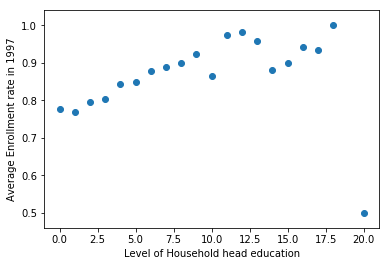

In [45]:
plt.scatter(avg_enroll_hohedu.hohedu,avg_enroll_hohedu.sc)
plt.xlabel("Level of Household head education")
plt.ylabel("Average Enrollment rate in 1997")

The average enrollment rate in 1997 has a steady rise in the range 0.75 upto 0.94 when the Level of education of the household head is upto 9. However, a drop in enrollment is observed at 10. The average enrollment rate shows a steady rise again for the level 11 and 12, followed again by a drop and rise. At level 20, the average enrollment rate is 0.5. This can be explained as we have comparatively less data for this level i.e. only two records with 1 as enrolled and the other as not enrolled.

### 1.5 Graphical exploration, part 2

Create a histogram of village enrollment rates **among poor households in treated villages**, before and after treatment. Specifically, for each village, calculate the average rate of enrollment of poor households in treated villages in 1997, then compute the average rate of enrollment of poor households in treated villages in 1998. Create two separate histograms showing the distribution of these average enrollments rates, one histogram for 1997 and one histogram for 1998. On each histogram, draw a vertical line that intersects the x-axis at the average value (across all households).
* Does there appear to be a difference? Is this difference statistically significant?
* Which D estimator in Schultz (2004) does this approach correspond to?

In [49]:
#Subset data
avg_treatment_before = progresa[(progresa.poor==1)&(progresa.year==97)&(progresa.progresa==1)].groupby(['village']).mean()
avg_treatment_after = progresa[(progresa.poor==1)&(progresa.year==98)&(progresa.progresa==1)].groupby(['village']).mean()
avg_treatment_before=avg_treatment_before.reset_index()
avg_treatment_before=avg_treatment_before.reset_index()
avg_treatment_before.sc

0      0.751773
1      0.681818
2      0.916667
3      0.960000
4      0.964912
5      0.916667
6      0.710526
7      0.857143
8      0.784314
9      0.751037
10     0.901639
11     0.636943
12     0.852459
13     0.887097
14     0.989247
15     0.948276
16     0.735294
17     0.882353
18     0.950820
19     0.816568
20     0.857143
21     0.816901
22     0.875000
23     0.868421
24     0.853659
25     0.785047
26     0.857143
27     0.872093
28     0.841463
29     0.898305
         ...   
290    0.875000
291    0.822222
292    0.671875
293    0.835165
294    0.680000
295    0.975610
296    0.894737
297    0.906667
298    0.863636
299    0.921053
300    0.933333
301    0.882353
302    0.944444
303    0.853659
304    0.900000
305    0.657143
306    0.871429
307    0.916667
308    0.863636
309    0.712329
310    0.833333
311    0.761905
312    0.818182
313    0.700000
314    0.750000
315    0.945946
316    0.777778
317    0.625000
318    0.758621
319    0.851852
Name: sc, dtype: float64

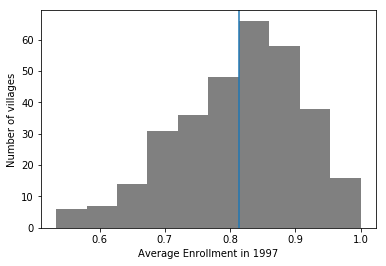

In [47]:
#Plot histogram for 1997
fig = plt.figure()
ax = plt.hist(avg_treatment_before.sc,color="grey")
plt.ylabel("Number of villages")
plt.xlabel("Average Enrollment in 1997")
plt.axvline(avg_treatment_before.sc.mean())

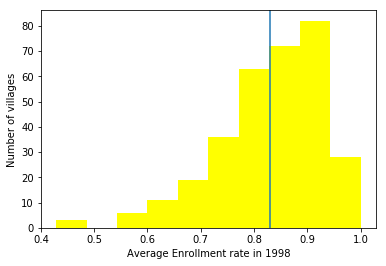

In [23]:
fig = plt.figure()
ax = plt.hist(avg_treatment_after.sc, color = "yellow")
plt.ylabel("Number of villages")
plt.xlabel("Average Enrollment rate in 1998")
plt.axvline(avg_treatment_after.sc.mean())

In [56]:
print ("Mean of average enrollment rate in 1997:", avg_treatment_before.sc.mean())
print ("Mean of average enrollment rate in 1998:", avg_treatment_after.sc.mean())

Mean of average enrollment rate in 1997: 0.8138394110596501
Mean of average enrollment rate in 1998: 0.8295362042630732


In [57]:
t = ttest_ind(avg_treatment_after.sc,avg_treatment_before.sc)
print (t)

Ttest_indResult(statistic=2.0157134865156379, pvalue=0.04424870036572115)


* The mean values before and after the treatment differ by a small amount.
  A t-test confirms that the difference is statistically significant as the p-value < 0.05, although marginally.

* It corresponds to the D estimator DD1 = D1(post-program) - D1(pre-program) > 0 with the difference being that the post and pre program groups do not consider the control population and is limited to the treatment population

## Part 2: Measuring Impact

### 2.1 Simple differences: T-test

Start out by estimating the impact of Progresa using "simple differences." Restricting yourself to data from 1998 (after treatment).
* calculate the average enrollment rate among **poor** households in the Treatment villages and the average enrollment rate among **poor** households in the control villages.
* Which difference estimator in Schultz (2004) does this approach correspond to?
* Use a t-test to determine if this difference is statistically significant. What do you conclude?

In [58]:
treatment_98 = progresa[(progresa.poor==1) & (progresa.progresa==1) & (progresa.year==98)]
control_98 = progresa[(progresa.poor==1) & (progresa.progresa==0) & (progresa.year==98)]

#Average enrollment rate in the treatment and control group in 1998
print ("Average enrollment rate in treatment villages in 1998: ", treatment_98.sc.mean() )
print ("Average enrollment rate in control villages in 1998: ", control_98.sc.mean())

#t test to determine statistical significance
ttest_ind(treatment_98.sc[~np.isnan(treatment_98.sc)],control_98.sc[~np.isnan(control_98.sc)])

Average enrollment rate in treatment villages in 1998:  0.8464791213954308
Average enrollment rate in control villages in 1998:  0.807636956730308


Ttest_indResult(statistic=8.3587205674183735, pvalue=6.636344447523235e-17)

* There is some difference in the avg. enrollment rate among the treatment and control villages in 1998. Using the t-test, we determine that the difference is statistically significant. We can conclude that the impact of progresa is evident in the year 1998 among the two groups.
* This corresponds to the difference estimator in Schultz:
Program - Control Difference in Outcomes among Comparable-Eligible Groups          
D1(t) = S(1,t) - S(2,t) where t = 2, S(1,t) = Treatment poor group, S(2,t) = Control poor group

### 2.2 Simple differences: Regression

Estimate the effects of Progresa on enrollment using a regression model, by regressing the 1998 enrollment rates **of the poor** on treatment assignment. Discuss the following:

* Based on this model, how much did Progresa increase the likelihood of a child enrolling?
* How does your regression estimate compare to your t-test estimate from part 2.1?
* Based on this regression model, can we reject the null hypothesis that the treatment effects are zero? 
* What is the counterfactual assumption underlying this regression?

In [59]:
progresa_98 = progresa[(progresa.poor == 1) & (progresa.year == 98)]

lm = smf.ols(formula='sc ~ progresa', data=progresa_98).fit()
print (lm.params)
print (lm.summary())

Intercept        0.807637
progresa[T.1]    0.038842
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     69.87
Date:                Mon, 01 May 2017   Prob (F-statistic):           6.64e-17
Time:                        22:01:19   Log-Likelihood:                -11926.
No. Observations:               27450   AIC:                         2.386e+04
Df Residuals:                   27448   BIC:                         2.387e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------

* Based on the linear regression model, Progresa increases the likelihood of enrolling by 0.038842. The intercept value of 0.807637 indicates the average enrollment rate in the absence of the Progresa program.
* Calculating the effect of Progresa in the linear regression model - 0.8076 + (1 x 0.0388) = 0.8464.
This matches the average enrollment rate in the treatment villages obtained from the simple differences test.
* We can reject the null hypothesis, as the p-value obtained is below 0.05. It is statistically significant and implies that the progresa treatment did have a statistically significant effect.
* The counterfactual assumption is that in the absence of the treatment effect, the average enrollment rate in the treatment group would match the average enrollment rate in the control group.

*
*
*
*

### 2.3 Multiple Regression

Re-run the above regression estimated but this time include a set of control variables. Include, for instance, age, distance to a secondary school, gender, education of household head, indigenous, etc.

* How do the controls affect the point estimate of treatment effect?
* How do the controls affect the standard error on the treatment effect? 
* How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?

In [29]:
multiple_lm = smf.ols(formula ='sc ~ progresa + age + dist_sec + sex + hohedu + indig + fam_n + min_dist+ hohage + hohedu', 
                      data = progresa_98).fit()
print(multiple_lm.params)
print(multiple_lm.summary())

Intercept        1.460867
progresa[T.1]    0.032992
age             -0.065743
dist_sec        -0.011358
sex              0.030410
hohedu           0.008567
indig            0.028895
fam_n            0.000253
min_dist         0.000615
hohage           0.000109
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     1135.
Date:                Mon, 01 May 2017   Prob (F-statistic):               0.00
Time:                        21:41:41   Log-Likelihood:                -7590.0
No. Observations:               27336   AIC:                         1.520e+04
Df Residuals:                   27326   BIC:                         1.528e+04
Df Model:                           9                                         
Covariance Typ

* The controls in the multiple regression model reduced the point estimate of the treatment effect to 0.033 from 0.0388 in the single regression model.

* The controls reduced the standard error from 0.005 in the single regression model to 0.004 in the multiple regression model.

* Differences(or similarities) in the estimates -
a)The intercept has increased from 0.8076 (Single regression model) to 1.4609 (Multiple regression model) which implies that while controlling for multiple factors, the avg. enrollment would have increased considerabely in the absence of the treatment.
b)With the controls in the multiple regression model, the R squared value = 0.272, indicating the model explains the variations in the data better than the single regression model.
c)In the multiple regression model, it is observed that with an increase in age by 1 year, the avg. enrollment rate reduces by 0.0657 while holding the other factors constant and similarly with an increase in  distance to secondary school by 1 unit, the avg. enrollment rate reduces by 0.0114 while holding the other factors constant.

### 2.4 Difference-in-Difference, version 1 (tabular)

Thus far, we have computed the effects of Progresa by estimating the difference in 1998 enrollment rates across villages. An alternative approach would be to compute the treatment effect using a difference-in-differences framework.

Begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998. Specifically, calculate the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages; then compute the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages. The difference between these two differences is your estimate.

* What is your estimate of the impact, and how does it compare to your earlier (simple difference) results?
* What is the counterfactual assumption underlying this estimate? 


In [60]:
#Subsetting data
treatment_97 = progresa[(progresa.year==97)&(progresa.poor==1)&(progresa.progresa==1)]
treatment_98 = progresa[(progresa.year==98)&(progresa.poor==1)&(progresa.progresa==1)]
control_97 = progresa[(progresa.year==97)&(progresa.poor==1)&(progresa.progresa==0)]
control_98 = progresa[(progresa.year==98)&(progresa.poor==1)&(progresa.progresa==0)]

#Average enrollment rate in each
avg_enroll_treatment_97 = treatment_97.sc.mean()
avg_enroll_treatment_98 = treatment_98.sc.mean()
avg_enroll_control_97 = control_97.sc.mean()
avg_enroll_control_98 = control_98.sc.mean()

dd_df = pd.DataFrame([[avg_enroll_treatment_97,avg_enroll_control_97],[avg_enroll_treatment_98,avg_enroll_control_98]]
                    ,columns = ['Average Enrollment - Treatment Group','Average Enrollment - Control Group']
                    ,index = ['1997 (Before Treatment)','1998 (After Treatment)'])
print ("Difference - in - Difference is: ", (avg_enroll_treatment_98 - avg_enroll_control_98) - (avg_enroll_treatment_97 - avg_enroll_control_97) )
dd_df

Difference - in - Difference is:  0.031331280319323085


,Average Enrollment - Treatment Group,Average Enrollment - Control Group
1997 (Before Treatment),0.822697,0.815186
1998 (After Treatment),0.846479,0.807637


* The estimate of the treatment impact is 0.03133. The impact of the treatment is reduced compared to the simple difference result of 0.0388 obtained in the single regression model. As established previously that the randomization process did not obtain ideal results, the difference in difference model is a better estimate of the treatment impact.
* The counterfactual assumption is that difference-in-difference value would have been 0, i.e the average enrollment difference between the treatment group and control group would have been the same in 97 and 98, in the absence of the treatment.

### 2.5 Difference-in-Difference, version 1 (regression)

Now use a regression specification to estimate the average treatment effect of the program (on the poor) in a difference-in-differences framework. Include at least 5 control variables.

* What is your estimate of the impact of Progresa? Be very specific in interpreting your coefficients and standard errors, and make sure to specify exactly what units you are measuring and estimating.
* How do these estimates of the treatment effect compare to the estimates based on the simple difference?
* How do these estimates compare to the difference-in-difference estimates from 2.4 above? What accounts for these differences?
* What is the counterfactual assumption underlying this regression? 

In [61]:
#Create variable to identify 97 - before treatment and 98 - after treatment
progresa.loc[progresa.year == 97, 'after'] = 0
progresa.loc[progresa.year == 98, 'after'] = 1

progresa_97_98_poor = progresa[((progresa.after == 1) | (progresa.after == 0)) & (progresa.poor == 1)]

double_diff_lm = smf.ols(formula = 'sc ~ progresa + after + progresa:after + age + dist_sec + sex + hohedu + indig + fam_n + min_dist+ hohage + hohedu',
                data=progresa_97_98_poor).fit()
double_diff_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     2081.
Date:                Mon, 01 May 2017   Prob (F-statistic):               0.00
Time:                        22:45:46   Log-Likelihood:                -16562.
No. Observations:               58157   AIC:                         3.315e+04
Df Residuals:                   58145   BIC:                         3.326e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept               1.4282      0.010    146.029      0.000         1.409     1.447
progresa[T.1]           0.0020      0.004      0.527      0.598        -0.005     0.009
after                   0.0273      0.004      6.279      0.000         0.019     0.036
progresa[T.1]:after     0.0313      0.006      5.692      0.000         0.021     0.042
age                    -0.0658      0.000   -143.647      0.000        -0.067    -0.065
dist_sec               -0.0103      0.001    -16.679      0.000        -0.011    -0.009
sex                     0.0333      0.003     12.456      0.000         0.028     0.038
hohedu                  0.0078      0.001     13.472      0.000         0.007     0.009
indig                   0.0329      0.003     10.899      0.000         0.027     0.039
fam_n                  -0.0002      0.001     -0.365      0.715        -0.001     0.001
min_dist                0.0006   3.39e-05     16.959      0.000         0.001     0.001
hohage                  0.0003      0.000      2.549      0.011      7.65e-05     0.001
==============================================================================
Omnibus:                     5461.777   Durbin-Watson:                   1.491
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7167.479
Skew:                          -0.858   Prob(JB):                         0.00
Kurtosis:                       3.108   Cond. No.                         914.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* The estimate of the impact of Progresa is 0.0313. To obtain this result, the year variable was changed to after = 1 (1998) and after = 0 (1997). It is observed that considering the treatment impact in 1998 is the same as the result obtained in 2.5.
There is an increase in average enrollment in the treatment group in 1998 with 0.0313 as the new coefficient while controlling for other variables, with a standard error of 0.006.

* The estimates obtained here are lower than the simple difference as it considers the difference in the treatment and control group prior to the treatment. Hence the estimate is more precise.

* This estimate is equal to the one obtained in 2.4. A marginal difference in the decimal values can be attributed to the control variables introduced.

* The counterfactual assumption is that the difference in difference value would have been 0, i.e the average enrollment difference between the treatment group and control group would have been the same in 97 and 98, in the absence of the treatment.

### 2.6 Difference-in-Difference, version 2

In the previous problem, you estimated a difference-in-differences model that compared changes in enrollment rates over time across treatment and control villages. An alternative approach would be to compare enrollment rates in 1998 between poor and non-poor across treatment and control villages. 

* How would we estimate this version of the treatment effects in a regression model? 
* What is the counterfactual assumption underlying this regression?
* How do these treatment effects compare to the estimates above?
* Discuss some possible explanations for differences or similarities 

In [62]:
progresa_98 = progresa[(progresa.year==98)]
double_diff_lm_2 = smf.ols(formula = 'sc ~ progresa + poor + progresa:poor + age + dist_sec + sex + hohedu + indig + fam_n + min_dist + hohage + hohedu',
                          data = progresa_98).fit()
double_diff_lm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     1090.
Date:                Mon, 01 May 2017   Prob (F-statistic):               0.00
Time:                        22:47:27   Log-Likelihood:                -9240.6
No. Observations:               31971   AIC:                         1.851e+04
Df Residuals:                   31959   BIC:                         1.861e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                   1.4900      0.015     97.077      0.000         1.460     1.520
progresa[T.1]               0.0251      0.010      2.592      0.010         0.006     0.044
poor[T.1]                  -0.0197      0.008     -2.373      0.018        -0.036    -0.003
progresa[T.1]:poor[T.1]     0.0078      0.011      0.742      0.458        -0.013     0.028
age                        -0.0662      0.001   -102.438      0.000        -0.067    -0.065
dist_sec                   -0.0116      0.001    -13.905      0.000        -0.013    -0.010
sex                         0.0305      0.004      8.428      0.000         0.023     0.038
hohedu                      0.0092      0.001     12.164      0.000         0.008     0.011
indig                       0.0299      0.004      7.116      0.000         0.022     0.038
fam_n                      -0.0008      0.001     -1.059      0.290        -0.002     0.001
min_dist                    0.0006   4.57e-05     13.413      0.000         0.001     0.001
hohage                      0.0002      0.000      0.883      0.377        -0.000     0.001
==============================================================================
Omnibus:                     3170.045   Durbin-Watson:                   1.730
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4220.534
Skew:                          -0.888   Prob(JB):                         0.00
Kurtosis:                       3.109   Cond. No.                     1.23e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* The point estimate of the treatment is 0.0251 which is higher than the value obtained in 2.5 of 0.0020, indicating that the effect of progresa is statistically significant.
The point estimate of the poor variable with a value -0.0197 is no surprise as when the household is poor, the avg. enrollment  decreases by 0.0197.
Considering progresa[T.1]:poor[T.1] variable i.e. the combined condition of progresa treatment in a poor household shows that the effect of progresa is positive. For every poor household in the treatment program, the avg. enrollment rate increases by 0.0078. However, the impact is not statistically significant.

* The counterfactual assumption is that the avg. enrollment remains the same between poor and non-poor households across treatment and control villages.

* The treatment effects are different from the estimates above as the impact of progresa in increasing the avg enrollment on poor households is less than the impact of progresa on non-poor households. That is, within the poor households the estimate as previously calculated is 0.0313 indicating a high impact. However, the effect of progresa in poor households when compared to non-poor households is reduced by 0.0078, although it is not statistically significant.

* A similarity is observed in the fact that overall progresa treatment has a positive effect in the avg. enrollment irrespective of poor/ non-poor household as shown by the progresa coefficients. Both models seem to be explaining the variations in the data well. The double difference(treatment vs. control in poor households) across time model explains the data well with a higher R- squared value of 0.282. The difference in estimates is aggravated as this model is not across time. We do not know the difference between the poor and non-poor households prior to treatment. 

### 2.7 Spillover effects (extra credit)

Thus far, we have focused on the impact of PROGRESA on poor households. Repeat your analysis in 2.5, using a double-difference regression to estimate the impact of PROGRESA on non-poor households. In other words, compare the difference in enrollments between 1997 and 1998 for non-poor households in treatment villages with the difference in enrollments between 1997 and 1998 for non-poor households in control villages.

* A: Describe one or two reasons why PROGRESA might have impacted non-poor households.
* B: Do you observe any impacts of PROGRESA on the non-poor?
* C: What is the identifying assumption that you are using to estimate the impact of PROGRESA on non-poor households.

In [91]:
progresa_no_poor = progresa[(progresa.poor == 0) & ((progresa.year==97)|(progresa.year==98))]
dd_lm = smf.ols(formula = 'sc ~ progresa + after + progresa:after + age + dist_sec + sex + hohedu + indig + fam_n + min_dist + hohage + hohedu',
                           data = progresa_no_poor).fit()
print ("The number of non-poor households in treatment group: ", len(progresa_no_poor[(progresa_no_poor.progresa == 1) & (progresa_no_poor.year==98)]))
dd_lm.summary()

The number of non-poor households in treatment group:  3558


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     380.8
Date:                Mon, 01 May 2017   Prob (F-statistic):               0.00
Time:                        19:46:10   Log-Likelihood:                -3670.4
No. Observations:               10378   AIC:                             7365.
Df Residuals:                   10366   BIC:                             7452.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept               1.5134      0.026     58.249      0.000         1.462     1.564
progresa[T.1]           0.0264      0.009      2.842      0.004         0.008     0.045
after                   0.0393      0.011      3.644      0.000         0.018     0.060
progresa[T.1]:after    -0.0025      0.014     -0.182      0.855        -0.030     0.025
age                    -0.0687      0.001    -59.859      0.000        -0.071    -0.066
dist_sec               -0.0157      0.002     -8.895      0.000        -0.019    -0.012
sex                     0.0297      0.007      4.382      0.000         0.016     0.043
hohedu                  0.0096      0.001      8.061      0.000         0.007     0.012
indig                   0.0299      0.010      2.912      0.004         0.010     0.050
fam_n                  -0.0052      0.001     -3.534      0.000        -0.008    -0.002
min_dist                0.0005   8.48e-05      6.383      0.000         0.000     0.001
hohage                  0.0004      0.000      1.197      0.231        -0.000     0.001
==============================================================================
Omnibus:                      855.491   Durbin-Watson:                   1.497
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              812.874
Skew:                          -0.624   Prob(JB):                    3.07e-177
Kurtosis:                       2.434   Cond. No.                         857.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* A: Progresa might have impacted non-poor households as the increase in avg. enrollment among poor households might have been observed by non-poor households which would have prompted them to enroll there children to maintain a competitive edge over the non-poor households.
* B: Interstingly, the impact of progresa on non-poor household is -0.0025 which shows a decrease in avg. enrollment. However, this value is not statistically significant. It is observed the overall impact of progresa is 0.0264 in the treatment group vs the control group across the years which is statistically significant.
* C: Without progressa, the increase in avg. enrollment rate would be the same in the treatment and control groups in the non-poor households.

### 2.8 Summary

Based on all the analysis you have undertaken to date, do you think that Progresa had a causal impact on the enrollment rates of poor households in Mexico?

Yes, Progresa did have a causal impact on the enrollment rates of poor households in Mexico. The causal impact is not significant but is definetely observed among treatment groups in the poor households. Additional spill-over effects with an increase in avg. enrollment among non-poor households also shows that the Progresa study is having a positive impact on increasing the overall enrollment rate in the community.